In [1]:
import glob
import librosa
import librosa.display
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy

# 

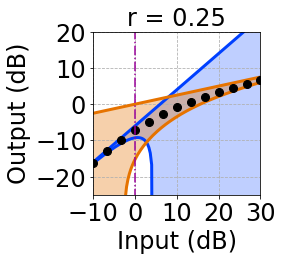

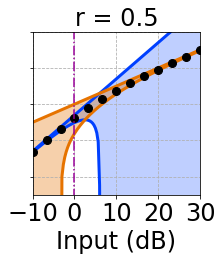

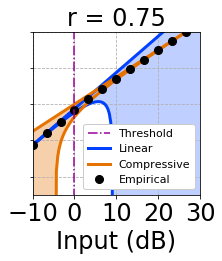

In [2]:
%matplotlib inline

settings = {
    "fmin": 0,
    "fmax": 10000,
    "hop_length": 1024,
    "n_fft": 2048,
    "n_mels": 128,
    "sr": 22050,
    "win_length": 2048,
    "window": "hann",
    "T": 0.05,#0.400,
    "alpha": 0.96,#0.98
    "delta": 2.0,
    "r": 0.5,
    "eps": 1e-10}


bias = 1.0
figsize = (3, 3)


for power in [0.25, 0.5, 0.75]:
    G = np.logspace(-2, 4, 181)
    PCEN = (G + bias)**power - bias**power


    fig = plt.figure(figsize=figsize)

    min_G = 10**(-2.0)
    max_G = 10**(+2.0)


    legend_linear, = plt.plot(
        10*np.log10(G),
        10*np.log10(G * bias**(power-1) * power),
        color="#0040FF",
        label="Linear",
        linewidth=3.0)

    plt.plot(
        10*np.log10(G),
        10*np.log10(np.maximum(1e-10, PCEN * (1 - (1-power)/2 * G))),
        color="#0040FF",
        linewidth=3.0)

    plt.fill_between(
        10*np.log10(G),
        10*np.log10(G * bias**(power-1) * power),
        10*np.log10(np.maximum(1e-10, PCEN * (1 - (1-power)/2 * G))),
        alpha = 0.25,
        color="#0040FF")

    legend_compressive, = plt.plot(
        10*np.log10(G),
        10*np.log10(G ** power),
        color="#E67300",
        label="Compressive",
        linewidth=3.0)

    plt.plot(
        10*np.log10(G),
        10*np.log10(np.maximum(1e-10, PCEN *
                            (1 - (1-power)/(G**power) * (1 + power / (2*G**power))))),
        color="#E67300",
        linewidth=3.0)

    plt.fill_between(
        10*np.log10(G),
        10*np.log10(np.maximum(1e-10, PCEN *
                            (1 - (1-power)/(G**power) * (1 + power / (2*G**power))))),
        10*np.log10(G ** power),
        alpha = 0.33,
        color="#E67300"
    )

    legend_empirical, = plt.plot(
        10*np.log10(G[::10]),
        10*np.log10(PCEN[::10]),
        'o',
        color='k',
        markersize=8.0,
        label="Empirical");

    fig.axes[0].grid(linestyle='--')

    plt.xlabel("Input (dB)", fontsize=24)
    
    if power == 0.25:
        plt.ylabel("Output (dB)", fontsize=24)

    plt.xlim([-10, 30])
    plt.xticks([-10, 0, 10, 20, 30], fontsize=24)
    plt.ylim([-25, 15])
    plt.yticks([-20, -10, 0, 10, 20], fontsize=24)
    if not power == 0.25:
        plt.gca().set_yticklabels(["", "", "", "", ""])
    
    plt.title("r = " + str(power), fontsize=24)
    
    legend_threshold = plt.plot([0, 0], [-1e6, 1e6], '-.',
        color='#990099', label='Threshold')
    

    fig.savefig('bode_compressor_{:3.1f}.png'.format(power),
                transparent=True, bbox_inches="tight", dpi=1000)
    
    
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20.0, 0.35), frameon=False)
plt.gca().axis('off')


legend_handles = [
    legend_threshold[0], legend_linear, legend_compressive, legend_empirical]
legs = []
xs = [0.18, 0.335, 0.562, 0.75]

for h, x in zip(legend_handles, xs):
    leg = plt.legend(handles=[h],
        fontsize=24, bbox_to_anchor=(x, 1.80))
    leg.get_frame().set_alpha(1)
    legs.append(leg)

for leg in legs:
    plt.gca().add_artist(leg)
    
fig.savefig('bode_compressor_legend.png',
            transparent=True, bbox_inches="tight", dpi=1000)


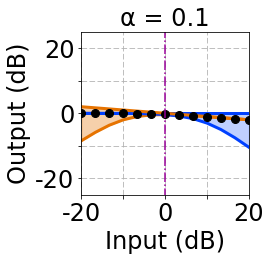

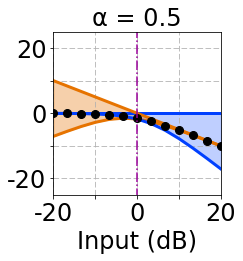

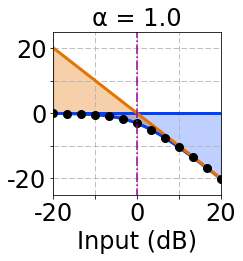

In [99]:
figsize = (3, 3)
eps = 1.0
M = eps * np.logspace(-2, 2, 13)

for gain in [0.1, 0.5, 1.0]:

    denom = (M + eps)**(-gain)

    fig = plt.figure(figsize=figsize)

    plt.plot(
        10*np.log10(M),
        10*np.log10(np.maximum(1e-10,M**(-gain) / (1 + gain*eps/M))),
        color="#E67300",
        linewidth=3.0)
    plt.fill_between(
        10*np.log10(M),
        10*np.log10(M**(-gain)),
        10*np.log10(np.maximum(1e-10,M**(-gain) / (1 + gain*eps/M))),
        alpha = 0.33,
        color="#E67300"
    )

    plt.plot(
        10*np.log10(M),
        10*np.log10(np.ones(M.size) * eps**(-gain)),
        color="#0040FF",
        linewidth=3.0)
    plt.plot(
        10*np.log10(M),
        10*np.log10(np.maximum(1e-10, eps**(-gain) / (1 + gain*M/eps))),
        color="#0040FF",
        linewidth=3.0)
    plt.fill_between(
        10*np.log10(M),
        10*np.log10(np.ones(M.size) * eps**(-gain)),
        10*np.log10(np.maximum(1e-10,eps**(-gain) / (1 + gain*M/eps))),
        alpha = 0.25,
        color="#0040FF"
    )

    plt.plot(
        10*np.log10(M),
        10*np.log10(M**(-gain)),
        color="#E67300",
        linewidth=3.0)
    plt.plot(10*np.log10(M), 10*np.log10(denom),
        'o',
        color='k',
        markersize=8.0)


    fig.axes[0].grid(linestyle='--')

    plt.xlabel("Input (dB)", fontsize=24)
    
    if gain == 0.1:
        plt.ylabel("Output (dB)", fontsize=24)

    plt.xlim([-20, 20])
    plt.xticks([-20, -10, 0, 10, 20])
    plt.gca().set_xticklabels(["-20", "", "0", "", "20"], fontsize=24)
    plt.ylim([-25, 25])
    plt.yticks([-20, -10, 0, 10, 20])
    plt.gca().set_yticklabels(["-20", "", "0", "", "20"], fontsize=24)
    
    plt.title("α = " + str(gain), fontsize=24)
    
    legend_threshold = plt.plot([0, 0], [-1e6, 1e6], '-.',
        color='#990099', label='Threshold')
    

    plt.show()
    fig.savefig('bode_renorm_{:3.1f}.png'.format(gain),
                transparent=True, bbox_inches="tight", dpi=1000)


0.0497997826183
0.0497946367622


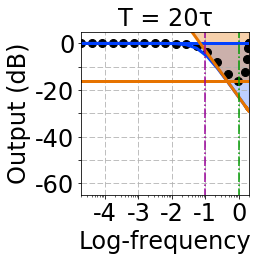

0.00499979959348
0.00499979438578


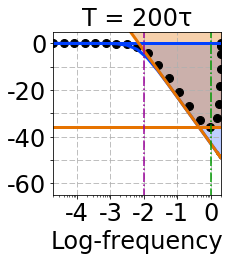

0.00049999979963
0.000499999794381


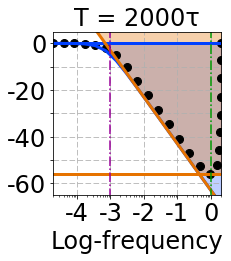

ValueError: Can not reset the axes.  You are probably trying to re-use an artist in more than one Axes which is not supported

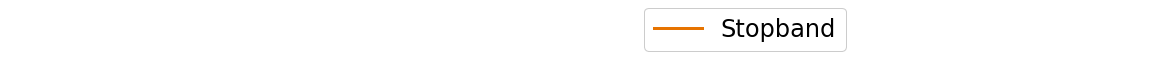

In [101]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

Ts = [20, 200, 2000]

for T in Ts:
    
    K = np.cos(2*np.pi/T)
    s = np.sqrt(1 - K) * (np.sqrt(3-K) - np.sqrt(1-K))
    
    N = 10000
    ω0 = (s / np.sqrt(1-s)) / (2*np.pi)
    ωc = np.arccos(1 - ω0**2/2)
    print(ωc)
    print(ω0)
    ω = np.concatenate(
        (np.logspace(-5, 0, 17),
         np.array([0.78, 0.9, 0.96, 0.983, 0.993, 0.9973, 0.999])))
    ωref = 0.5 # Nyquist
    π = np.pi
    α = 1 - ω

    #h_diff = ((2/s)/(2**2) + 1/s**2) * (2*π*ω)**2
    #h_lf = h_diff + 2
    #h_hf = (2/s * np.sin(2*π*ω/2)**2)**2 
    #h = (1 + 2/s * np.sin(2*π*ω/2)**2)**2 + (1/s * np.sin(2*π*ω))**2 the form below is simpler
    #plt.loglog(ω/ω0, h_diff, '-', color="#E67300", linewidth=3.0)
    #plt.loglog(ω/ω0, h_lf, '-', color="#E67300", linewidth=3.0)
    #plt.fill_between(
    #    ω/ω0, h_diff, h_lf, alpha = 0.33, color="#E67300")
    #plt.plot(ω/ω0, np.minimum(h_diff, h_hf), '-', color="#E67300", linewidth=3.0)
    #plt.fill_between(
    #    ω/ω0, h_hf, h_diff, alpha = 0.33, color="#E67300")


    h = s**2 / (s**2 + 2 * (1-s) * (1-np.cos(2*π*ω)))
    h_lfinf = np.ones(ω.size)
    h_lfsup = s**2 / (s**2 + 2 * (1-s) * (2*π*ω)**2)
    h_hfinf = s**2 / (2 * (1-s) * (2*π*ω)**2)
    h_hfsup = s**2 / (s**2 + 4 * (1-s)) * np.ones(ω.size)
    #h_hfsup = 1 + 4*(1+s)/(s**2) * (π*ω)**2

    fig = plt.figure(figsize=figsize)

    legend_empirical = plt.semilogx(ω / ωref, 10*np.log10(h), 'o',
        color='k', markersize=8.0, label='Empirical')

    legend_passband, = plt.semilogx(ω / ωref, 10*np.log10(h_lfsup), '-',
        color="#0040FF", linewidth=3.0, label="Passband")
    plt.semilogx(ω / ωref, 10*np.log10(h_lfinf), '-', color="#0040FF", linewidth=3.0)
    plt.fill_between(
        ω / ωref,
        10*np.log10(h_lfinf), 10*np.log10(h_lfsup),
        alpha = 0.25, color="#0040FF")

    legend_stopband, = plt.semilogx(ω / ωref, 10*np.log10(h_hfinf), '-',
        color="#E67300", linewidth=3.0, label="Stopband")
    plt.semilogx(ω / ωref, 10*np.log10(h_hfsup), '-', color="#E67300", linewidth=3.0)
    plt.fill_between(
        ω / ωref, 10*np.log10(np.maximum(h_hfinf, h_hfsup)),
        10 * np.ones(ω.size), alpha = 0.33, color="#E67300")

    legend_cutoff = plt.plot([ωc/ωref, ωc/ωref], [-1e6, 1e6], '-.',
        color='#990099', label='Cutoff')
    
    legend_nyquist = plt.plot([1.0, 1.0], [-1e6, 1e6], '-.',
        color='#009900', label='Nyquist')

    fig.axes[0].grid(linestyle='--')

    plt.xlim([np.max(ω/ωref)*1e-5, np.max(ω/ωref)])
    plt.ylim([-65, 5])
    plt.yticks([-60, -50, -40, -30, -20, -10, 0])
    plt.gca().set_yticklabels(
        ["-60", "", "-40", "", "-20", "", "0"], fontsize=24)

    plt.xlabel("Log-frequency", fontsize=24)
    plt.gca().set_xticklabels(
        ["", "", "-4", "-3", "-2", "-1", "0"], fontsize=24)
    
    if T==20:
        plt.ylabel("Output (dB)", fontsize=24)
    
    plt.title("T = " + str(T) + "τ", fontsize=24)
    
    plt.show()

    fig.savefig('frequency_response_T={}.png'.format(T),
                transparent=True, bbox_inches="tight", dpi=1000)
    



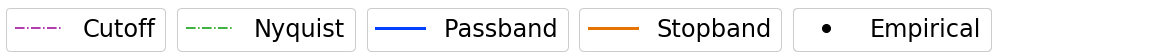

In [129]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20.0, 0.35), frameon=False)
plt.gca().axis('off')

legend_handles = [legend_cutoff[0], legend_nyquist[0],
    legend_passband, legend_stopband,
    legend_empirical[0]]
xs = [0.14, 0.31, 0.501, 0.692, 0.88]

legs = []
for h, x in zip(legend_handles, xs):
    leg = plt.legend(handles=[h],
        fontsize=24, bbox_to_anchor=(x, 1.80))
    leg.get_frame().set_alpha(1)
    legs.append(leg)

for leg in legs:
    plt.gca().add_artist(leg)
    
fig.savefig('frequency_response_legend.png',
            transparent=True, bbox_inches="tight", dpi=1000)

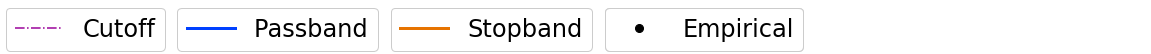

In [146]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20.0, 0.35), frameon=False)
plt.gca().axis('off')

legend_handles = [legend_cutoff[0],
    legend_passband, legend_stopband,
    legend_empirical[0]]
xs = [0.14, 0.331, 0.523, 0.712]

legs = []
for h, x in zip(legend_handles, xs):
    leg = plt.legend(handles=[h],
        fontsize=24, bbox_to_anchor=(x, 1.80))
    leg.get_frame().set_alpha(1)
    legs.append(leg)

for leg in legs:
    plt.gca().add_artist(leg)
    
fig.savefig('frequency_response_legend.png',
            transparent=True, bbox_inches="tight", dpi=1000)